In [2]:
import numpy as np
import pandas as pd

import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [3]:
from pyballmapper import BallMapper
from pyballmapper.plotting import graph_GUI
from bokeh.plotting import figure, show

from matplotlib import colormaps as cm

In [4]:
# this cell allows for bokeh plots to be displayed inside jupyter notebooks
from bokeh.io import output_notebook

# output_notebook()

## Preprocessing

In [5]:
def check_victory(c, s):  # c array of configurations, s symbol
    c = c.reshape(3, 3)

    target = [s, s, s]  # target

    for row in c:
        if list(row) == target:
            return True
    for row in c.T:
        if list(row) == target:
            return True

    # check diagonals
    if list(c.diagonal()) == target:
        return True
    if list(np.fliplr(c).diagonal()) == target:
        return True

    # if here, return false
    return False

In [6]:
data = pd.read_csv(
    "../data/tic-tac-toe.data", header=None, names=[i for i in range(9)] + ["outcome"]
)

In [7]:
data

,0,1,2,3,4,5,6,7,8,outcome
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


In [8]:
my_outcome = []

for row in data[[i for i in range(9)]].values:
    if check_victory(row, "x"):
        my_outcome.append(1)
    elif check_victory(row, "o"):
        my_outcome.append(-1)
    else:
        my_outcome.append(0)

data["my_outcome"] = my_outcome

In [9]:
data

,0,1,2,3,4,5,6,7,8,outcome,my_outcome
0,x,x,x,x,o,o,x,o,o,positive,1
1,x,x,x,x,o,o,o,x,o,positive,1
2,x,x,x,x,o,o,o,o,x,positive,1
3,x,x,x,x,o,o,o,b,b,positive,1
4,x,x,x,x,o,o,b,o,b,positive,1
...,...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative,0
954,o,x,o,x,x,o,x,o,x,negative,0
955,o,x,o,x,o,x,x,o,x,negative,0
956,o,x,o,o,x,x,x,o,x,negative,0


In [10]:
data.my_outcome.value_counts()

my_outcome
 1    626
-1    316
 0     16
Name: count, dtype: int64

In [11]:
data_num = data.replace(
    {"x": "1", "o": "-1", "b": "0", "positive": "1", "negative": "-1"}
).astype(int)

In [12]:
data_num

,0,1,2,3,4,5,6,7,8,outcome,my_outcome
0,1,1,1,1,-1,-1,1,-1,-1,1,1
1,1,1,1,1,-1,-1,-1,1,-1,1,1
2,1,1,1,1,-1,-1,-1,-1,1,1,1
3,1,1,1,1,-1,-1,-1,0,0,1,1
4,1,1,1,1,-1,-1,0,-1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
953,-1,1,1,1,-1,-1,-1,1,1,-1,0
954,-1,1,-1,1,1,-1,1,-1,1,-1,0
955,-1,1,-1,1,-1,1,1,-1,1,-1,0
956,-1,1,-1,-1,1,1,1,-1,1,-1,0


In [13]:
number_of_moves = []

for game in data_num.iloc[:, :9].values:
    number_of_moves.append(np.count_nonzero(game))

data_num["number_of_moves"] = number_of_moves

In [14]:
data_num.outcome.value_counts()

outcome
 1    626
-1    332
Name: count, dtype: int64

In [15]:
data_num.my_outcome.value_counts()

my_outcome
 1    626
-1    316
 0     16
Name: count, dtype: int64

In [16]:
data_num["number_of_moves"].value_counts()

number_of_moves
7    444
8    168
6    148
5    120
9     78
Name: count, dtype: int64

In [17]:
# now we can distinguish the 12 draw configurations
data_num[data_num.outcome != data_num.my_outcome]

,0,1,2,3,4,5,6,7,8,outcome,my_outcome,number_of_moves
942,1,1,-1,-1,1,1,1,-1,-1,-1,0,9
943,1,1,-1,-1,-1,1,1,1,-1,-1,0,9
944,1,1,-1,-1,-1,1,1,-1,1,-1,0,9
945,1,-1,1,1,1,-1,-1,1,-1,-1,0,9
946,1,-1,1,1,-1,1,-1,1,-1,-1,0,9
947,1,-1,1,1,-1,-1,-1,1,1,-1,0,9
948,1,-1,1,-1,1,1,-1,1,-1,-1,0,9
949,1,-1,1,-1,-1,1,1,1,-1,-1,0,9
950,1,-1,-1,-1,1,1,1,1,-1,-1,0,9
951,-1,1,1,1,1,-1,-1,-1,1,-1,0,9


## Standard BM

In [18]:
X = data_num.iloc[:, :9].to_numpy(dtype=float)
y = data_num[["my_outcome", "number_of_moves"]]

print(X.shape, y.shape)

(958, 9) (958, 2)


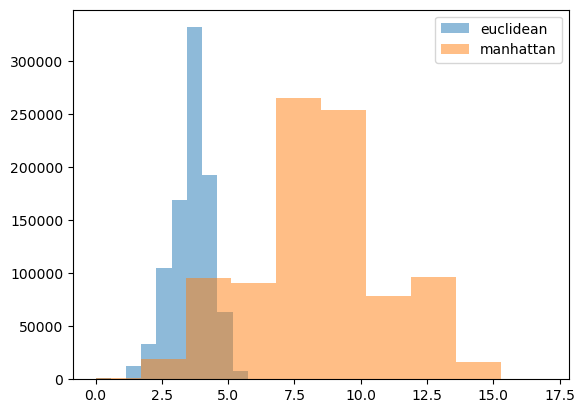

In [19]:
from sklearn.metrics import pairwise_distances

plt.hist(
    pairwise_distances(X, X, metric="euclidean").flatten(), label="euclidean", alpha=0.5
)
plt.hist(
    pairwise_distances(X, X, metric="manhattan").flatten(), label="manhattan", alpha=0.5
)
plt.legend()
plt.show()

In [20]:
np.unique(pairwise_distances(X, X, metric="euclidean").flatten())

array([0.        , 1.41421356, 1.73205081, 2.        , 2.23606798,
       2.44948974, 2.64575131, 2.82842712, 3.        , 3.16227766,
       3.31662479, 3.46410162, 3.60555128, 3.74165739, 3.87298335,
       4.        , 4.12310563, 4.24264069, 4.35889894, 4.47213595,
       4.58257569, 4.69041576, 4.79583152, 4.89897949, 5.        ,
       5.09901951, 5.19615242, 5.38516481, 5.65685425, 5.74456265])

In [ ]:
np.unique(pairwise_distances(X, X, metric="manhattan").flatten())

### Euclidean BM

In [ ]:
EPS_EUC = np.sqrt(3)  # connects at sqrt(3)

ttt_euc_bm = BallMapper(
    X=X,  # the pointcloud, as a numpy array
    eps=EPS_EUC,
)


print(len(ttt_euc_bm.Graph.nodes))

ttt_euc_bm.add_coloring(coloring_df=y[["my_outcome"]])

my_red_palette = cm.get_cmap("Reds")
my_euc_gui = graph_GUI(
    ttt_euc_bm.Graph,
    my_red_palette,
)
my_euc_gui.color_by_variable("my_outcome")

show(my_euc_gui.plot)

### manhattan BM

In [ ]:
# from scipy.spatial.distance import cityblock

# EPS_CB = 3  # connects at 3

# ttt_cb_bm = BallMapper(
#     X=X, eps=EPS_CB, metric=cityblock  # the pointcloud, as a numpy array
# )

# print(len(ttt_cb_bm.Graph.nodes))

# ttt_cb_bm.add_coloring(coloring_df=y[["my_outcome"]])

# my_red_palette = cm.get_cmap("Reds")
# my_euc_gui = graph_GUI(
#     ttt_cb_bm.Graph,
#     my_red_palette,
# )
# my_euc_gui.color_by_variable("my_outcome")

# show(my_euc_gui.plot)

In [ ]:
nx.is_isomorphic(ttt_cb_bm.Graph, ttt_euc_bm.Graph)

## Orbit 8

In [21]:
X = data_num.iloc[:, :9].to_numpy(dtype=float)
y = data_num[["my_outcome"]]

print(X.shape, y.shape)

(958, 9) (958, 1)


In [22]:
def are_equivalent(conf1, conf2):

    to_check = [
        conf2.tolist(),  # ID
        np.rot90(conf2.reshape(3, 3), k=1).reshape(-1).tolist(),  # R 90
        np.rot90(conf2.reshape(3, 3), k=2).reshape(-1).tolist(),  # R 180
        np.rot90(conf2.reshape(3, 3), k=3).reshape(-1).tolist(),  # R 270
        conf2.reshape(3, 3)[:, ::-1].reshape(-1).tolist(),  # L vertical
        conf2.reshape(3, 3)[::-1, :].reshape(-1).tolist(),  # L horizontal
        conf2.reshape(3, 3).T.reshape(-1).tolist(),  # L diagonal 1
        conf2.reshape(3, 3)[::-1, ::-1]
        .T.reshape(-1)
        .tolist(),  # L diagonal 2 (rotate and transpose)
    ]

    if conf1.tolist() in to_check:
        return True
    else:
        return False

In [23]:
orbits = []

for conf1 in tqdm(X):
    this_orbit = []
    for i, conf2 in enumerate(X):
        if are_equivalent(conf1, conf2):
            this_orbit.append(i)
    orbits.append(this_orbit)

y["orbit_id"] = [min(o) for o in orbits]

  0%|          | 0/958 [00:00<?, ?it/s]

/var/folders/4s/_33kvc6507v69vbr_vy9xsjc0000gq/T/ipykernel_28195/401924797.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["orbit_id"] = [min(o) for o in orbits]


In [24]:
orbits[:10]

[[0, 23, 160, 388],
 [1, 22, 79, 158, 297, 328, 334, 376],
 [2, 21, 80, 115, 132, 176, 306, 378],
 [3, 26, 82, 199, 316, 478, 557, 616],
 [4, 25, 101, 197, 491, 544, 582, 584],
 [5, 24, 103, 161, 402, 480, 495, 614],
 [6, 55, 81, 278, 307, 415, 574, 598],
 [7, 54, 83, 251, 315, 453, 465, 470],
 [8, 53, 102, 249, 420, 440, 490, 569],
 [9, 36, 84, 202, 308, 416, 547, 572]]

In [71]:
data_num["len_orbit"] = [len(o) for o in orbits]

data_num["len_orbit"].value_counts()

len_orbit
8    832
4    120
2      4
1      2
Name: count, dtype: int64

In [72]:
data_num[data_num["len_orbit"] == 1]

,0,1,2,3,4,5,6,7,8,outcome,my_outcome,number_of_moves,orbit_id,len_orbit
124,1,-1,1,-1,1,-1,1,-1,1,1,1,9,124,1
319,-1,1,-1,1,1,1,-1,1,-1,1,1,9,319,1


In [73]:
X[124].reshape((3, 3))

array([[ 1., -1.,  1.],
       [-1.,  1., -1.],
       [ 1., -1.,  1.]])

In [74]:
X[319].reshape((3, 3))

array([[-1.,  1., -1.],
       [ 1.,  1.,  1.],
       [-1.,  1., -1.]])

In [25]:
data_num["orbit_id"] = [min(o) for o in orbits]

In [26]:
data_num

,0,1,2,3,4,5,6,7,8,outcome,my_outcome,number_of_moves,orbit_id
0,1,1,1,1,-1,-1,1,-1,-1,1,1,9,0
1,1,1,1,1,-1,-1,-1,1,-1,1,1,9,1
2,1,1,1,1,-1,-1,-1,-1,1,1,1,9,2
3,1,1,1,1,-1,-1,-1,0,0,1,1,7,3
4,1,1,1,1,-1,-1,0,-1,0,1,1,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,-1,1,1,1,-1,-1,-1,1,1,-1,0,9,943
954,-1,1,-1,1,1,-1,1,-1,1,-1,0,9,942
955,-1,1,-1,1,-1,1,1,-1,1,-1,0,9,943
956,-1,1,-1,-1,1,1,1,-1,1,-1,0,9,942


In [68]:
data_num.my_outcome.value_counts()

my_outcome
 1    626
-1    316
 0     16
Name: count, dtype: int64

In [27]:
data_num.orbit_id.value_counts()[0]

4

In [28]:
data_num[data_num.number_of_moves == 5]

,0,1,2,3,4,5,6,7,8,outcome,my_outcome,number_of_moves,orbit_id
33,1,1,1,-1,-1,0,0,0,0,1,1,5,33
43,1,1,1,-1,0,-1,0,0,0,1,1,5,43
47,1,1,1,-1,0,0,-1,0,0,1,1,5,47
48,1,1,1,-1,0,0,0,-1,0,1,1,5,48
49,1,1,1,-1,0,0,0,0,-1,1,1,5,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,0,0,0,1,1,1,-1,0,-1,1,1,5,362
622,0,0,0,1,1,1,0,-1,-1,1,1,5,355
623,0,0,0,-1,-1,0,1,1,1,1,1,5,33
624,0,0,0,-1,0,-1,1,1,1,1,1,5,43


### Euclidean

In [82]:
EPS_EQ = np.sqrt(5)

ttt_euc_bm_EQ = BallMapper(
    X=X,  # the pointcloud, as a numpy array
    eps=EPS_EQ,
    orbits=orbits,
)  # the radius of the balls

ttt_euc_bm_EQ.add_coloring(data_num[["my_outcome", "orbit_id", "number_of_moves"]])

my_palette = cm.get_cmap("tab10")

my_euc_gui = graph_GUI(
    ttt_euc_bm_EQ.Graph,
    my_palette,
    ["my_outcome", "orbit_id", "number_of_moves"],
)
# title='ttt Euclidean BM with all symms eps={}'.format(EPS_EQ))
my_euc_gui.color_by_variable("number_of_moves")

show(my_euc_gui.plot)

color by variable number_of_moves 
MIN_VALUE: 6.241, MAX_VALUE: 8.200


In [76]:
ttt_euc_bm_EQ.Graph.nodes[41]

{'landmark': 324,
 'points covered': array([324, 325, 326, 339, 341, 342, 348, 360, 361, 362, 499, 511, 512,
        513, 523]),
 'size': 15,
 'my_outcome': 1.0,
 'orbit_id': 262.6,
 'number_of_moves': 6.333333333333333,
 'size rescaled': 17.344827586206897,
 'color': '#1f77b4'}

In [26]:
X[8].reshape((3, 3))

array([[ 1.,  1.,  1.],
       [ 1., -1.,  0.],
       [ 0., -1., -1.]])

In [27]:
X[20].reshape((3, 3))

array([[ 1.,  1.,  1.],
       [-1.,  1.,  0.],
       [ 0., -1., -1.]])

In [28]:
pairwise_distances([X[8], X[20]], [X[77]])

NameError: name 'pairwise_distances' is not defined

### Cityblock

In [ ]:
# EPS_CB = 3

# ttt_cb_bm_EQ = BallMapper(
#     X=X, eps=EPS_CB, orbits=orbits, metric=cityblock  # the pointcloud, as a numpy array
# )

# ttt_cb_bm_EQ.add_coloring(data_num[["my_outcome", "orbit_id", "number_of_moves"]])

# my_palette = cm.get_cmap("Reds_r")

# my_euc_gui = graph_GUI(
#     ttt_cb_bm_EQ.Graph,
#     my_palette,
#     ["my_outcome", "orbit_id", "number_of_moves"],
# )
# # title='ttt Euclidean BM with all symms eps={}'.format(EPS_CB))
# my_euc_gui.color_by_variable("my_outcome")

# show(my_euc_gui.plot)

In [ ]:
### Check they are the same
nx.is_isomorphic(ttt_cb_bm_EQ.Graph, ttt_euc_bm_EQ.Graph)

## Color by orbits

In [36]:
## count how many different orbits in the BM

orbits_id_dict = {}

i = 0
for node in ttt_euc_bm_EQ.Graph.nodes:
    landmark = ttt_euc_bm_EQ.landmarks[node]
    if (y.orbit_id[landmark] not in orbits_id_dict) and (
        ttt_euc_bm_EQ.Graph.nodes[node]["my_outcome"]
        == -1  # color only the winning cluster
    ):
        orbits_id_dict[y.orbit_id[landmark]] = i
        i += 1

orbits_id_dict

{626: 0, 629: 1, 640: 2, 643: 3, 651: 4, 657: 5, 659: 6, 663: 7, 665: 8}

In [37]:
## shuffle the colors
rng = np.random.default_rng(seed=24)
shuffle = rng.choice(len(orbits_id_dict), len(orbits_id_dict), replace=False)


for i, key in enumerate(orbits_id_dict.keys()):
    orbits_id_dict[key] = shuffle[i]

orbits_id_dict

{626: 6, 629: 0, 640: 1, 643: 5, 651: 2, 657: 8, 659: 7, 663: 4, 665: 3}

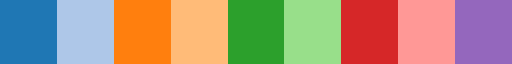

In [38]:
N = len(orbits_id_dict)
my_palette = matplotlib.colors.ListedColormap(sns.color_palette("tab20", N))
my_palette

In [39]:
N

9

In [40]:
my_euc_gui.my_palette = my_palette

for node in my_euc_gui.bokeh_graph.nodes:
    landmark = ttt_euc_bm_EQ.landmarks[node]
    my_euc_gui.bokeh_graph.nodes[node]["color"] = matplotlib.colors.to_hex(
        my_euc_gui.my_palette(orbits_id_dict.get(y.orbit_id[landmark], 99) / N)
    )

    my_euc_gui.bokeh_graph.nodes[node]["orbit_id"] = y.orbit_id[landmark]


my_euc_gui.graph_renderer.node_renderer.data_source.data["color"] = [
    my_euc_gui.bokeh_graph.nodes[n]["color"] for n in my_euc_gui.bokeh_graph.nodes
]
my_euc_gui.graph_renderer.node_renderer.data_source.data["orbit_id"] = [
    my_euc_gui.bokeh_graph.nodes[n]["orbit_id"] for n in my_euc_gui.bokeh_graph.nodes
]

show(my_euc_gui.plot)

## interactive VIZ

In [83]:
from matplotlib.colors import to_rgb

In [62]:
from pyballmapper.plotting import kmapper_visualize

kmapper_visualize(
    ttt_euc_bm_EQ,
    coloring_df=data_num[["my_outcome", "orbit_id", "number_of_moves"]],
    path_html="output.html",
)

In [63]:
colorscale_default = [  # Viridis
    [0.0, "rgb(68, 1, 84)"],
    [0.1, "rgb(72, 35, 116)"],
    [0.2, "rgb(64, 67, 135)"],
    [0.3, "rgb(52, 94, 141)"],
    [0.4, "rgb(41, 120, 142)"],
    [0.5, "rgb(32, 144, 140)"],
    [0.6, "rgb(34, 167, 132)"],
    [0.7, "rgb(68, 190, 112)"],
    [0.8, "rgb(121, 209, 81)"],
    [0.9, "rgb(189, 222, 38)"],
    [1.0, "rgb(253, 231, 36)"],
]

In [64]:
colorscale_red = [
    [
        i / 10,
        "rgb{}".format(
            tuple((round(f * 255) for f in cm.get_cmap("Reds")(i / 10)[:3]))
        ),
    ]
    for i in range(0, 11)
]
colorscale_red

[[0.0, 'rgb(255, 245, 240)'],
 [0.1, 'rgb(254, 229, 216)'],
 [0.2, 'rgb(253, 202, 181)'],
 [0.3, 'rgb(252, 171, 143)'],
 [0.4, 'rgb(252, 138, 106)'],
 [0.5, 'rgb(251, 105, 74)'],
 [0.6, 'rgb(241, 68, 50)'],
 [0.7, 'rgb(217, 37, 35)'],
 [0.8, 'rgb(188, 20, 26)'],
 [0.9, 'rgb(152, 12, 19)'],
 [1.0, 'rgb(103, 0, 13)']]

b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x01,\x08\x06\x00\x00\x00y}\x8eu\x00\x00\x009tEXtSoftware\x00Matplotlib version3.8.4, https://matplotlib.org/\x1f%#u\x00\x00\x00\tpHYs\x00\x00\x0fa\x00\x00\x0fa\x01\xa8?\xa7i\x00\x00\x04(IDATx\x9c\xed\xd6\xc1iCQ\x0cEA?\xe3\xf2\x92\x9e~JJ\x81Ai\xc0\x01/\x02\xe2\xe0\x99\x06tW\x07\x9d\x99\x99\x1b@\xc0}{\x00\xc0\xab\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, \xe3\xb1=\xe0/\xd79\xdb\x13\x80'\xae\x99\xb5\xdb>, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, C\xb0\x80\x0c\xc1\x022\x04\x0b\xc8\x10, 

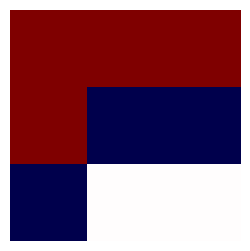

In [65]:
with io.BytesIO() as output:
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(X[3].reshape((3, 3)), cmap="seismic")
    ax.axis("off")
    fig.savefig(output)

    print(output.getvalue())

In [66]:
import io
import sys
import base64
from PIL import Image
import copy

# Create images for a custom tooltip array
tooltip_s = []
for image_data in tqdm(X):
    with io.BytesIO() as output:
        # big_array = (
        #     (zoom(image_data.reshape((3, 3)), 30, order=0) + 1) / 2 * 255
        # ).astype(np.uint8)
        # img = Image.fromarray(big_array)
        # img.save(output, "PNG")
        fig, ax = plt.subplots(figsize=(0.7, 0.7))
        ax.imshow(image_data.reshape((3, 3)), cmap="seismic")
        ax.axis("off")
        plt.tight_layout()
        fig.savefig(output)
        contents = copy.deepcopy(output.getvalue())
        img_encoded = base64.b64encode(contents)
        img_tag = """<img src="data:image/png;base64,{}">""".format(
            img_encoded.decode("utf-8")
        )
        tooltip_s.append(img_tag)
        plt.close()

tooltip_s = np.array(
    tooltip_s
)  # need to make sure to feed it as a NumPy array, not a list

  0%|          | 0/958 [00:00<?, ?it/s]

In [84]:
from pyballmapper.plotting import kmapper_visualize

kmapper_visualize(
    ttt_euc_bm_EQ,
    coloring_df=data_num[["my_outcome", "orbit_id", "number_of_moves"]],
    path_html="output.html",
    custom_tooltips=tooltip_s,
    colorscale=colorscale_red,
)